<a href="https://colab.research.google.com/github/jtmonroe/FreeCodeCamp-Dog-Cat/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We ought to remove `ImageDataGenerator` since it is deprcated in the API. We can replace it with `image_dataset_from_directory` as per

In [1]:
import tensorflow as tf

from tensorflow.keras import optimizers, callbacks, losses, Sequential
from tensorflow.keras.layers import InputLayer, \
  Dense, Conv2D, Flatten, Dropout, MaxPooling2D, \
  Rescaling, Resizing, RandomFlip, RandomRotation, \
  RandomZoom, RandomSharpness, RandomContrast, BatchNormalization, \
  RandomTranslation, RandomBrightness
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset


import os
from pathlib import Path
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from functools import partial
from itertools import repeat

It takes longer to print the unzip of the files than it does to unzip them. Send to the null zone.

In [2]:
# Get project files
if not Path("cats_and_dogs.zip").exists():
  os.system("wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip")

if not Path("cats_and_dogs/").exists():
  os.system("unzip cats_and_dogs.zip > /dev/null")

In [3]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
cycles = 2
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# 3

from_directory = partial(image_dataset_from_directory,
                         label_mode="binary",
                         image_size=(IMG_HEIGHT, IMG_WIDTH)
                         )

train_image_dataset = from_directory(train_dir, labels='inferred', batch_size=batch_size)
validation_image_dataset = from_directory(validation_dir, labels='inferred', batch_size=batch_size)
test_image_dataset = from_directory(test_dir, labels=None, batch_size=total_test, shuffle=False)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files.


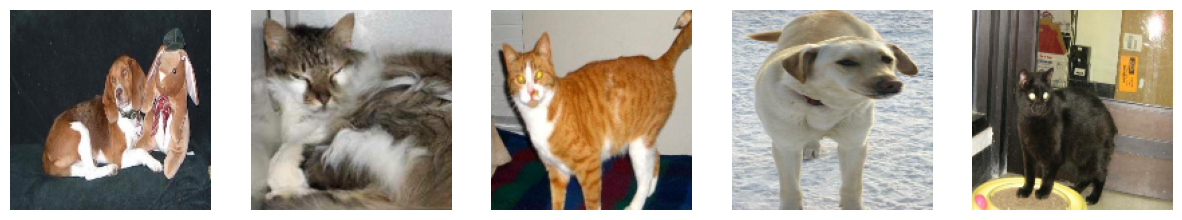

In [5]:
# 4

def is_accelerated() -> bool:
  """Check if we are in an accelerated env to change algorithm"""
  if "COLAB_GPU" in os.environ.keys():
    return True
  elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    return True
  else:
    return False

def first(iterable):
  return next(iter(iterable))

def plot_images(images_arr, probabilities: NDArray | None = None):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(len(images_arr) * 3, 5))

    if probabilities is None:
      for img, ax in zip(images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
      plt.show()
      return

    for img, probability, ax in zip(images_arr, probabilities, axes):
        ax.imshow(img)
        ax.axis('off')
        if probability > 0.5:
            ax.set_title("%.2f" % (probability*100) + "% dog")
        else:
            ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = first(train_image_dataset)
plot_images(Rescaling(1./255)(sample_training_images[:5]))


In [16]:
# 5 Doing this with Layers instead, we just have to iterate over the dataset more
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomContrast(0.1),
    RandomSharpness(0.1),
    RandomBrightness(0.3),
])

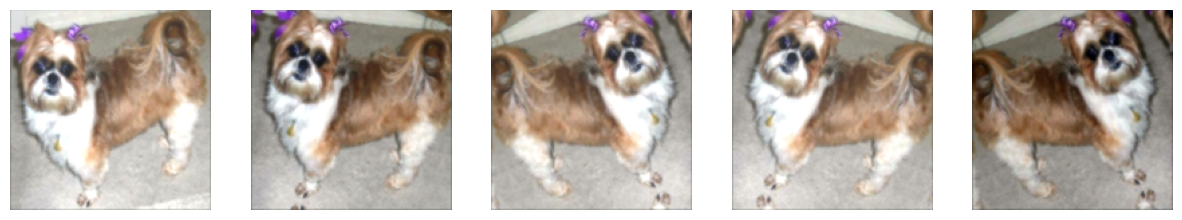

In [17]:
# 6
x, _ = first(train_image_dataset)
augmented_images = [data_augmentation(x)[0] for _ in range(5)]
plot_images(Rescaling(1./255)(augmented_images))

In [23]:
# 7
def ConvLayer(filters):
  kernel_size = 5
  if not is_accelerated():
    return [
      Conv2D(filters, kernel_size, activation='relu', padding='same', data_format="channels_last"),
      BatchNormalization(axis=-1),
      MaxPooling2D(),
    ]
  print("using accelerated")
  return [
    Conv2D(filters, kernel_size, activation='relu', padding='same', data_format="channels_first"),
    BatchNormalization(axis=1),
    MaxPooling2D(),
  ]


model = Sequential([
  InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  data_augmentation,
  Rescaling(1./255),
  *ConvLayer(16),
  *ConvLayer(32),
  *ConvLayer(64),
  Dropout(0.5),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(1, name = "out", activation='sigmoid')
])

model.summary()

using accelerated
using accelerated
using accelerated


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 150, 3)          │          60,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 150, 3)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 75, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 75, 3)           │           6,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 75, 3)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 37, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 37, 3)           │          25,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 37, 3)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1728)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,001 (1.20 MB)

 Trainable params: 313,777 (1.20 MB)

 Non-trainable params: 224 (896.00 B)

In [24]:
# 8

lr_schedule = optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=100,
  decay_rate=1,
  staircase=False
)

callback = callbacks.EarlyStopping(monitor='val_loss',
                                  mode="min",
                                  patience=3,
                                  restore_best_weights=True)

model.compile(
    loss=losses.BinaryCrossentropy(),
    metrics = ['accuracy'],
    optimizer=optimizers.Adam(lr_schedule)
)
history = model.fit(
    train_image_dataset.repeat().shuffle(batch_size),
    steps_per_epoch= cycles * (total_train // batch_size),
    validation_data=validation_image_dataset,
    epochs=epochs,
    # callbacks=[callback]
)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.5030 - loss: 1.1248 - val_accuracy: 0.5000 - val_loss: 0.7083
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5422 - loss: 0.7275 - val_accuracy: 0.4870 - val_loss: 0.6923
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.5430 - loss: 0.6930 - val_accuracy: 0.5590 - val_loss: 0.6898
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5728 - loss: 0.6836 - val_accuracy: 0.5510 - val_loss: 0.6855
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.5758 - loss: 0.6716 - val_accuracy: 0.5960 - val_loss: 0.6723
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5787 - loss: 0.6743 - val_accuracy: 0.6040 - val_loss: 0.6694
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.5808 - loss: 0.6692 - val_accuracy: 0.6050 - val_loss: 0.6647
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.5947 - loss: 0.6643 - val_accuracy: 0

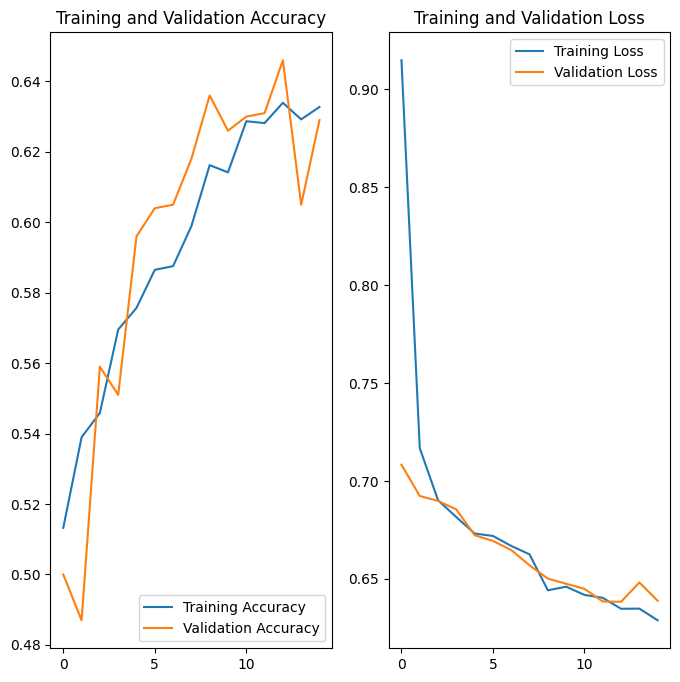

In [25]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# 10

probabilities = model.predict(test_image_dataset.repeat(), steps=4).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [29]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
